# Project: LeNet Convolutional Network MNIST


## Introduction
In this notebook, we aim to implement one of the most famous and original covolutional networks called the "LeNet", first proposed by Yann LeCun et al. in 1998. The implemented will be closer to the original model. We will then use the model to perform handwritten digit recognition using the MNIST dataset. We will use the PyTorch framework to build and train the model. In a separate notebook, we will also implement a multi-layer perceptron (MLP) model to perform the same task and then compare LeNet's performance against the MLP's both in their accuracy and robustness, as well as their translation invariance properties.

We will begin by importing the necessary packages and frameworks.

## Import Libraries and Packages

In [1]:
import numpy as np           
import matplotlib.pyplot as plt    
import pandas as pd
import torch          
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.functional as F

## Import Dataset and Preprocessing

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images_np = images.numpy()
labels_np = labels.numpy()

print(f'Batch shape: {images_np.shape}')  
print(f'Batch label shape: {labels_np.shape}')  

Batch shape: (64, 1, 28, 28)
Batch label shape: (64,)


## LeNet Architecture

In [3]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Average Pooling Layers
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Sigmoid as fully connected layer activation
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        # Forward prop
        
        # Layer 1 (conv + pool)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.activation(x)
        
        # Layer 2 (conv + pool)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.activation(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Dense Layers
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        
        return x

In [4]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model
model = LeNet()
print(model)

# Move the model to the device of choice
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (activation): Sigmoid()
)


## Model Training

In [5]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            values, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
log = []
for epoch in range(30):
    running_loss = 0
    
    for i, data in enumerate(trainloader, 0):
        # Input the training batch
        inputs, labels = data
        
        # Move data to the preferred device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reset the parameter gradients
        optimizer.zero_grad()
        
        # Forward prop
        outputs = model(inputs)
        
        # Loss
        loss = criterion(outputs, labels)
        log.append(loss.item()) 
        
        # Back prop
        loss.backward()
        optimizer.step()
        
        # Accumulate running loss
        running_loss += loss.item()
        
        # Print every 100 mini-batches
        if i % 200 == 99:
            print(f'Epoch [{epoch + 1}], Batch [{i + 1}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
    print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
    
print("Training Complete!")

Epoch [1], Batch [100], Loss: 2.2994
Epoch [1], Batch [500], Loss: 1.4060
Epoch [1], Batch [700], Loss: 0.9357
Epoch [1], Batch [900], Loss: 0.7174
Test Accuracy: 0.9128, Test Loss: 0.3038
Epoch [2], Batch [100], Loss: 0.3068
Epoch [2], Batch [300], Loss: 0.5651
Epoch [2], Batch [500], Loss: 0.5127
Epoch [2], Batch [700], Loss: 0.4527
Epoch [2], Batch [900], Loss: 0.4101
Test Accuracy: 0.9439, Test Loss: 0.1915
Epoch [3], Batch [100], Loss: 0.1816
Epoch [3], Batch [300], Loss: 0.3744
Epoch [3], Batch [500], Loss: 0.3311
Epoch [3], Batch [700], Loss: 0.3235
Epoch [3], Batch [900], Loss: 0.3023
Test Accuracy: 0.9576, Test Loss: 0.1425
Epoch [4], Batch [100], Loss: 0.1374
Epoch [4], Batch [300], Loss: 0.2733
Epoch [4], Batch [500], Loss: 0.2574
Epoch [4], Batch [700], Loss: 0.2496
Epoch [4], Batch [900], Loss: 0.2347
Test Accuracy: 0.9655, Test Loss: 0.1162
Epoch [5], Batch [100], Loss: 0.1248
Epoch [5], Batch [300], Loss: 0.2127
Epoch [5], Batch [500], Loss: 0.1970
Epoch [5], Batch [700]

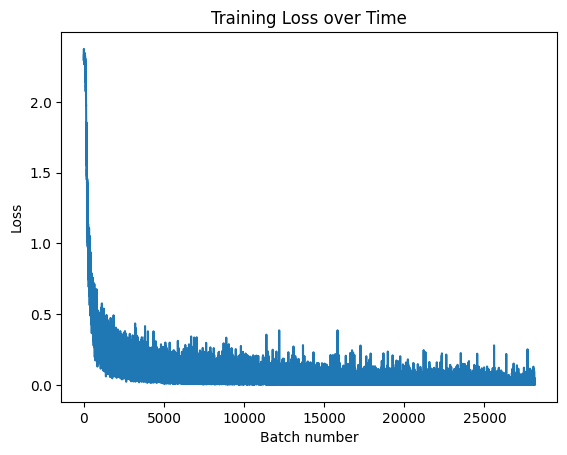

In [10]:
plt.plot(log)
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

## Evaluation

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            values, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluate on training data
train_loss, train_accuracy = evaluate(model, trainloader, criterion, device)
print(f'Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}')

# Evaluate on test data
test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

Training Accuracy: 0.9980, Training Loss: 0.0079
Test Accuracy: 0.9873, Test Loss: 0.0490


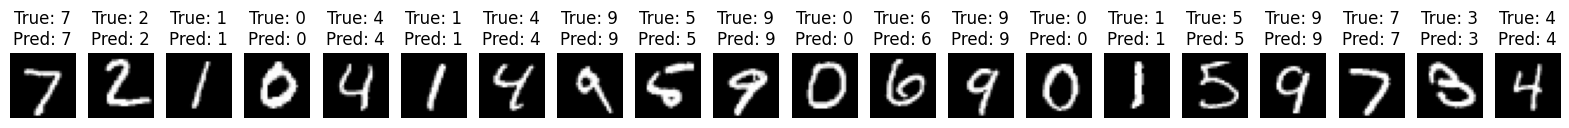

In [12]:
def visualize_predictions(model, testloader, device, num_images=20):
    model.eval()
    
    images, labels = next(iter(testloader))  # Get a batch of test images
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Move images and labels back to CPU for visualization
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()
    
    # Visualize the images with true and predicted labels
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'True: {labels[i]}\nPred: {predicted[i]}')
        ax.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, testloader, device)